# Attack Pipeline

This notebook captures the essense of our two-phase attack in reconstructing mobile trajectories from transmission metadata. Our attack is carried out on the campus of Peking University in Beijing, China across area that is 800m wide and 950m long. We simulated opportunistic connections between 60 stationary gateways and 12 mobile sensors, and collect metadata on connection times, gateway identity, and sensor identity.

The first phase takes the collected metadata and assumes we have the knowledge of a few of the gateways' locations. In practice, this data is easy to acquire as a network provider simply by deploying a few gateways in opportune areas (ideally with high traffic). We then attempt to reconstruct the locations of all other gateways in the area. We compare our predictions against the ground truth location information to see how well we did.

The second phase takes these predicted locations and reconstructs the mobile trajectories of the 12 sensors based on the sequence of gateways they connect to over time. We compare our predicted trajectory against the ground truth trajectory to see how well we did.

By carrying out this attack, we demonstrate the feasibility of mining rich location data from minimal network metadata and sparse knowledge of gateway locations. As such information reveals personal activity patterns and can be used in subsequent deanonymization attacks, it is imperative to hide this information in subsequent deployments of opportunistic networks.

# The Data

This section loads and visualizes our ground truth gateway locations and sensor trajectories. 

TODO: basically do `visualizing_success` here.

## Phase 1

We start this phase with knowledge of the locations of a few (~3) gateways. Using this knowledge along with the information from the metadata, we construct relative distances between gateways close to each other. We make the simplifying assumption that the sensors move at a constant speed.

Lines that can be edited to provide qualitatively different results will be marked with a `# !!` comment for easier idenfitication.

In [1]:
## Import the libraries.
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

In [2]:
## Construct a matrix of pairwise distances. This matrix may be sparse.

# This is the list of identifiers for the gateways that we know the positions of.
known_ids = [63, 64, 65, 66, 67, 68, 72, 73, 75] #[60 + i for i in range(16)] # [64 + i for i in range(5)] # !!
num_known = len(known_ids)

# Load in the ground truth positions of each stationary gateway.
truth_df = pd.read_csv('../ground_truth/gateways.csv')
num_gateways = len(truth_df)

# Iterate through all traces and generate distance matrices.
dist_diffs_list = []
unscaled_diffs_list = []
agg_speed = 0
for sensor_path in glob.iglob('../ground_truth/interactions/*.csv'):
    # Import the simulated mobile sensor connection metadata.
    sensor_df = pd.read_csv(sensor_path)

    # ideally we see at least three gateways
    if len(sensor_df['id'].unique()) < 3:
        continue
    
    # Calculate real-time seconds to avoid aggressive time-skips.
    secs_per_day = 86400
    sensor_df['time (secs)'] = (sensor_df['time'] - sensor_df['time'].iloc[0]) * secs_per_day

    # Subsample the connection data to take samples that are wider apart in time.
    sample_period = 8 # !!
    smol_df = sensor_df.loc[(sensor_df['time'].round() % sample_period) == 0]

    # Construct lists that hold the times taken to travel between each pair of gateways.
    time_diff_lists = [[[] for j in range(num_gateways)] for i in range(num_gateways)]
    # Do not consider relations between gateways further than cap_time seconds apart.
    cap_time = 2 * 60 # !!
    for i in range(len(smol_df)-1):
        cur_gateway = int(smol_df['id'].iloc[i])
        cur_time = smol_df['time (secs)'].iloc[i]

        j = 1
        next_gateway = int(smol_df['id'].iloc[i+j])
        next_time = smol_df['time (secs)'].iloc[i+j]
        time_diff = next_time - cur_time

        while time_diff < cap_time:
            time_diff_lists[cur_gateway][next_gateway].append(time_diff)
            time_diff_lists[next_gateway][cur_gateway].append(time_diff)

            j += 1
            if i+j >= len(smol_df):
                time_diff = cap_time
            else:
                next_gateway = int(smol_df['id'].iloc[i+j])
                next_time = smol_df['time (secs)'].iloc[i+j]
                time_diff = next_time - cur_time

    # Consolidate the lists of times into a matrix of pairwise times between adjacent gateways.
    # If we do not have any time values between two gateways, we use -1 to indicate no value.
    time_diffs = np.full((num_gateways, num_gateways), -1.0)
    for i in range(num_gateways-1):
        for j in range(i+1, num_gateways):
            times_list = time_diff_lists[i][j]
            if len(times_list) > 0:
                # We expect shorter times to be more representative of direct distance between gateways.
                time_diffs[[i,j],[j,i]] = np.percentile(times_list, 5) # !!

    # We use the time between known gateway positions to get an estimate for the speed of the mobile sensor.
    true_dists = np.zeros((num_known, num_known))
    for i in range(num_known):
        for j in range(num_known):
            dist = np.linalg.norm((truth_df[['x', 'y']].iloc[known_ids[i]] - truth_df[['x', 'y']].iloc[known_ids[j]]))
            true_dists[[i,j],[j,i]] = dist
    # Speed = distance / time. We assume the sensor travels at a constant speed.
    speeds = np.divide(true_dists, time_diffs[known_ids,:][:,known_ids])
    # If there is no time values to calculate speed with, we store this matrix and scale it later.
    if (speeds <= 0).all():
        unscaled_diffs_list.append(time_diffs)
    else:
        ave_speed = np.mean(speeds[speeds > 0]) # !!
        agg_speed += ave_speed
        # Using this estimate of speed, we can then estimate the pairwise distance matrix.
        dist_diffs = time_diffs * ave_speed
        dist_diffs_list.append(dist_diffs)

# Calculate the average speed over all valid trajectories in order to scale trajectories that
# we did not have enough information for. The assumption is that people in the same area move
# at about the same speed, which is completely invalid, but hopefully works well enough in practice.
'''
ave_agg_speed = agg_speed / len(dist_diffs_list)
for time_diffs in unscaled_diffs_list:
    dist_diffs_list.append(time_diffs * ave_agg_speed)
'''

# Consolidate the relative distance matrices.
dist_diffs = np.full((num_gateways, num_gateways), -1.0)
for i in range(num_gateways-1):
    for j in range(i+1, num_gateways):
        val_list = []
        for dist_mat in dist_diffs_list:
            if dist_mat[i,j] > 0:
                val_list.append(dist_mat[i, j])
        if len(val_list) > 0:
            dist_diffs[i,j] = np.median(val_list) # !!
            dist_diffs[j,i] = np.median(val_list) # !!

## Our pairwise distance matrix is called `dist_diffs`

In [3]:
print(len(unscaled_diffs_list))
print(len(dist_diffs_list))

595
42


In [4]:
num_adjusted = 1

while num_adjusted > 0:
    cur_index = 0
    num_adjusted = 0
    new_unscaled = []
    
    while cur_index < len(unscaled_diffs_list):
        next_times = unscaled_diffs_list[cur_index]
        mask = np.multiply(dist_diffs > 0, next_times > 0)
        if np.sum(mask) > 6:  # !!
            vel = np.mean(np.divide(dist_diffs, next_time)[mask])
            next_dists = next_times * vel
            dist_diffs_list.append(next_dists)
            num_adjusted += 1
            unscaled_diffs_list.pop(cur_index)
        else: 
            cur_index += 1
    
    # Consolidate the relative distance matrices.
    dist_diffs = np.full((num_gateways, num_gateways), -1.0)
    for i in range(num_gateways-1):
        for j in range(i+1, num_gateways):
            val_list = []
            for dist_mat in dist_diffs_list:
                if dist_mat[i,j] > 0:
                    val_list.append(dist_mat[i, j])
            if len(val_list) > 0:
                dist_diffs[i,j] = np.median(val_list) # !!
                dist_diffs[j,i] = np.median(val_list) # !!

In [5]:
print(len(unscaled_diffs_list))
print(len(dist_diffs_list))

580
57


In [6]:
# Reset the dist_diffs matrix really quick (don't do this normally)
"""
dist_diffs = np.full((num_gateways, num_gateways), -1.0)
for i in range(num_gateways-1):
    for j in range(i+1, num_gateways):
        val_list = []
        for dist_mat in dist_diffs_list[:43]:
            if dist_mat[i,j] > 0:
                val_list.append(dist_mat[i, j])
        if len(val_list) > 0:
            dist_diffs[i,j] = np.median(val_list) # !!
            dist_diffs[j,i] = np.median(val_list) # !!
"""

'\ndist_diffs = np.full((num_gateways, num_gateways), -1.0)\nfor i in range(num_gateways-1):\n    for j in range(i+1, num_gateways):\n        val_list = []\n        for dist_mat in dist_diffs_list[:43]:\n            if dist_mat[i,j] > 0:\n                val_list.append(dist_mat[i, j])\n        if len(val_list) > 0:\n            dist_diffs[i,j] = np.median(val_list) # !!\n            dist_diffs[j,i] = np.median(val_list) # !!\n'

In [7]:
## Construct predictions for the positions of each gateway by making iterative informed guesses.
# Try num_attempts random beginnings and select the results with the minimum loss.
num_attempts = 20
losses = np.zeros((num_attempts, num_gateways))
guess_mat = np.zeros((num_attempts, num_gateways, 2))
for attempt in tqdm(range(num_attempts)):
    # Randomly instantiate our position guesses within the area of interest.
    guesses = np.vstack([np.random.uniform(low=0.0, high=800.0, size=num_gateways),
                         np.random.uniform(low=0.0, high=950.0, size=num_gateways)]).T # !!
    # Instantiate position guesses to be the middle of the area of interest.
    #guesses = np.tile(np.array([[400, 475]]), [num_gateways, 1])

    # Populate our guesses with the positions for our known gateways.
    for known_id in known_ids:
        guesses[known_id] = truth_df[['x','y']].loc[truth_df['id'] == known_id]
    guess_mat[attempt] = guesses
        
    # Describe an error function to optimize.
    dist_diff = None
    def dist_err(point):
        # Have less confidence near unknown gateway locations.
        unknown_weight = 0.05 # !!
        errs = []
        for i in range(num_gateways):
            # Expected distance based on metadata calculations.
            dist = dist_diff[i]
            if dist > 0:
                # Current distance based on predicted positions.
                point_dist = np.linalg.norm(point - guesses[i])
                if i in known_ids:
                    errs.append(point_dist - dist)
                else:
                    errs.append((point_dist - dist)*unknown_weight)
        return np.array(errs)
    
    def known_err(point):
        # Only give errors from known gateway positions.
        errs = []
        for i in range(num_gateways):
            dist = dist_diff[i]
            if dist > 0 and i in known_ids:
                point_dist = np.linalg.norm(point - guesses[i])
                errs.append(point_dist - dist)
        if errs:
            return np.array(errs)
        return 0.0
    
    # Iteratively predict gateway positions to minimize the error function.
    num_iterations = 10 # !!
    for k in range(num_iterations):
        # Guess based only on distances from known positions
        for i in range(num_gateways):
            if i in known_ids:
                continue
            dist_diff = dist_diffs[i]
            guess_mat[attempt, i] = least_squares(known_err, guess_mat[attempt, i],
                                                  bounds=(np.array([0.0, 0.0]), np.array([800.0, 950.0])), # !!
                                                  loss='soft_l1').x # !!
        
        # Guess relative to all the placed gateways
        for i in range(num_gateways):
            # Do not need to predict the position of known gateways.
            if i in known_ids:
                continue
            dist_diff = dist_diffs[i]
            result = least_squares(dist_err, guess_mat[attempt, i],
                                   bounds=(np.array([0.0, 0.0]), np.array([800.0, 950.0])), # !!
                                   loss='soft_l1') # !!
            guess_mat[attempt, i] = result.x
            losses[attempt, i] = result.cost

# Consolidate the predicted positions
guess = np.array([guess_mat[opt, ind] for ind, opt in enumerate(np.argmin(losses, axis=0))])
#guess = np.mean(guess_mat, axis=0)

# Do one last optimization.
for i in range(num_gateways):
    if i in known_ids:
        continue
    dist_diff = dist_diffs[i]
    guess[i] = least_squares(known_err, guess[i],
                             bounds=(np.array([0.0, 0.0]), np.array([800.0, 950.0])), # !!
                             loss='soft_l1').x # !!
    
## Our final guesses for gateway positions are in `guess`

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.47s/it]


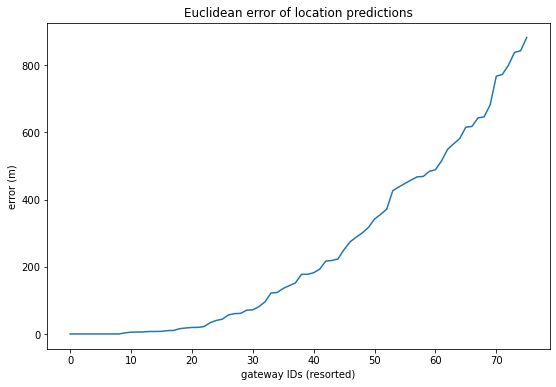

In [8]:
## Analyze our results numerically.

errors = guess - truth_df[['x', 'y']]
dist_errors = np.sort(np.linalg.norm(errors, axis=1))

plt.figure(figsize=(9, 6))
plt.title("Euclidean error of location predictions")
plt.xlabel("gateway IDs (resorted)")
plt.ylabel("error (m)")
plt.plot(dist_errors)
plt.show()

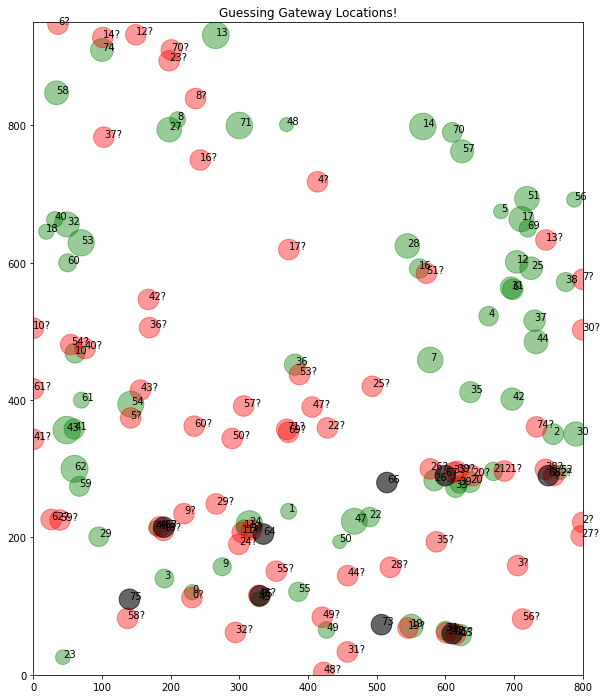

In [9]:
## Visualize the results.
# Known gateway positions are black.
# Ground truth (unknown) gateway positions are green.
# Predicted (unknown) gateway positions are red.

# Setup the figure.
plt.figure(figsize=(10,12))
plt.title("Guessing Gateway Locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
ax = plt.gca()
ax.set_aspect("equal")

# Plot ground truth gateway positions.
for index, row in truth_df.iterrows():
    if index not in known_ids:
        ax.add_patch(plt.Circle((row['x'], row['y']), row['r'], alpha = 0.4, color='g'))
        plt.text(row['x'], row['y'], int(row['id']))

# Plot known and predicted gateway positions.
for index, pos in enumerate(guess):
    if index in known_ids:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.6, color='k'))
        plt.text(pos[0], pos[1], index)
    else:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.4, color='r'))
        plt.text(pos[0], pos[1], "{}?".format(index))

# Display the figure.
plt.show()

Ok this is a little terrible. What if we only consider the gateways that we "see"?

In [10]:
seen_gateways = []
for i in range(num_gateways):
    if (i not in known_ids) and np.any(dist_diffs[i] > 0):
        seen_gateways.append(i)
print(seen_gateways)
print(len(seen_gateways))

[0, 2, 7, 9, 10, 11, 12, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 29, 30, 33, 34, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 55, 59, 60, 61, 62, 69]
41


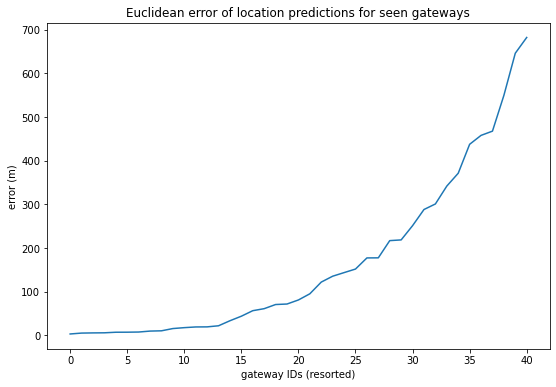

mean error: 166.09633161945737
median error: 81.18225679394999


In [11]:
dist_errors = np.sort(np.linalg.norm(errors, axis=1)[seen_gateways])

plt.figure(figsize=(9, 6))
plt.title("Euclidean error of location predictions for seen gateways")
plt.xlabel("gateway IDs (resorted)")
plt.ylabel("error (m)")
plt.plot(dist_errors)
plt.show()

print("mean error: {}".format(np.mean(dist_errors)))
print("median error: {}".format(np.median(dist_errors)))

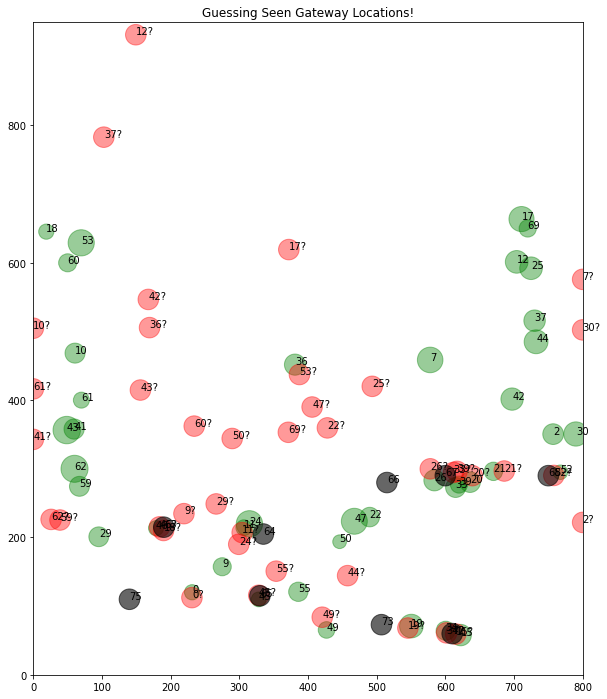

In [12]:
## Visualize the results.
# Known gateway positions are black.
# Ground truth (unknown) gateway positions are green.
# Predicted (unknown) gateway positions are red.

# Setup the figure.
plt.figure(figsize=(10,12))
plt.title("Guessing Seen Gateway Locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
ax = plt.gca()
ax.set_aspect("equal")

# Plot ground truth gateway positions.
for index, row in truth_df.iterrows():
    if (index not in known_ids) and (index in seen_gateways):
        ax.add_patch(plt.Circle((row['x'], row['y']), row['r'], alpha = 0.4, color='g'))
        plt.text(row['x'], row['y'], int(row['id']))

# Plot known and predicted gateway positions.
for index, pos in enumerate(guess):
    if index in known_ids:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.6, color='k'))
        plt.text(pos[0], pos[1], index)
    elif index in seen_gateways:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.4, color='r'))
        plt.text(pos[0], pos[1], "{}?".format(index))

# Display the figure.
plt.show()

In [13]:
# We can also restrict our estimates to gateways that we have seen at least 
# a few times that we are more confident about.
times_seen = np.zeros(num_gateways)
for matrix in dist_diffs_list:
    for index, row in enumerate(matrix):
        if np.any(row > 0):
            times_seen[index] += 1
            
print(times_seen)
print(max(times_seen))

[ 5.  0.  6.  0.  0.  0.  0.  2.  0.  1.  3.  8.  1.  0.  0. 14.  0.  2.
  1. 17. 11.  6. 18.  0. 11.  1. 14.  0.  0.  2.  8.  0.  0. 10. 17.  0.
  1.  1.  0. 11.  0.  4.  1.  3.  1. 11.  8. 20.  0.  4. 15.  0.  5.  1.
  0.  7.  0.  0.  0.  5.  1.  3.  6.  9. 11. 12. 14. 13. 10.  2.  0.  0.
 17. 18.  0.  5.]
20.0


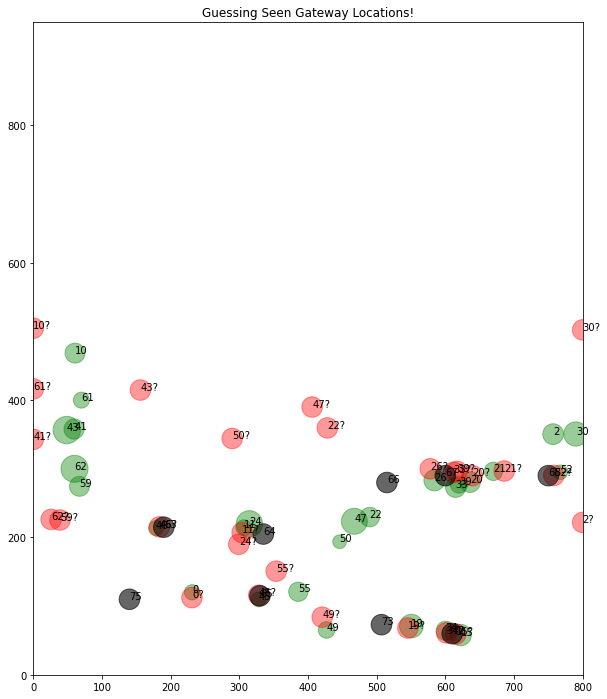

In [14]:
## Visualize the results.
# Known gateway positions are black.
# Ground truth (unknown) gateway positions are green.
# Predicted (unknown) gateway positions are red.

# Setup the figure.
plt.figure(figsize=(10,12))
plt.title("Guessing Seen Gateway Locations!")
plt.xlim([0, 800])
plt.ylim([0, 950])
ax = plt.gca()
ax.set_aspect("equal")

# Plot ground truth gateway positions.
for index, row in truth_df.iterrows():
    if (index not in known_ids) and (index in np.where(times_seen >= 3)[0]):
        ax.add_patch(plt.Circle((row['x'], row['y']), row['r'], alpha = 0.4, color='g'))
        plt.text(row['x'], row['y'], int(row['id']))

# Plot known and predicted gateway positions.
for index, pos in enumerate(guess):
    if index in known_ids:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.6, color='k'))
        plt.text(pos[0], pos[1], index)
    elif index in np.where(times_seen >= 3)[0]:
        ax.add_patch(plt.Circle(pos, 15, alpha=0.4, color='r'))
        plt.text(pos[0], pos[1], "{}?".format(index))

# Display the figure.
plt.show()

## Phase 2

After predicting the gateway locations, we then do a mobile trajectory reconstruction attack.

In [15]:
# Import libraries.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

In [16]:
def path_prediction(mobile_id=0, sample_period=4, spline_type='linear', filter_std=5):
    # Read in path simulation and ground truth files
    sim = pd.read_csv("../ground_truth/interactions/{}.csv".format(mobile_id))
    truth = pd.read_csv("../ground_truth/mules/{}.csv".format(mobile_id))
    
    # Downsample the simulation.
    down_sim = sim.loc[(sim['seconds'].round() % sample_period) == 0]
    
    # Compile positions of seen gateways.
    t = []
    sim_x = []
    sim_y = []

    for index, row in down_sim.iterrows():
        if (row['id'] in np.where(times_seen >= 3)[0]) or (row['id'] in known_ids):
            t.append(row['seconds'])
            sim_x.append(guess[int(row['id']), 0])
            sim_y.append(guess[int(row['id']), 1])
    
    
    # The goal is to spline. However, splines dont work well with multiple values
    # at one point, which happens when we see multiple gateways at the same time.
    # Thus, if we see multiple gateways at the same time, we average the positions.
    ct = []
    cx = []
    cy = []

    counter = 0
    while counter < len(t):
        cur_t = t[counter]
        cum_x = [sim_x[counter]]
        cum_y = [sim_y[counter]]
        counter += 1
        while counter < len(t) and t[counter] == cur_t:
            cum_x.append(sim_x[counter])
            cum_y.append(sim_y[counter])
            counter += 1
        ct.append(cur_t)
        cx.append(sum(cum_x) / len(cum_x))
        cy.append(sum(cum_y) / len(cum_y))
    
    
    # Calculate our predictions.
    fx = interp1d(ct, cx, kind=spline_type)
    fy = interp1d(ct, cy, kind=spline_type)
    tt = truth.loc[(truth['seconds'] > ct[0]) & 
                   (truth['seconds'] < ct[-1])]['seconds'].to_numpy()
    
    # Predict points based on a spline and apply a Gaussian filter to smooth the points.
    px = gaussian_filter1d(fx(tt), filter_std)
    py = gaussian_filter1d(fy(tt), filter_std)

    # Calculate the Euclidean error of the prediction for each truth point.
    err = []
    for i in range(len(tt)):
        ex = px[i] - truth.loc[truth['seconds'] == tt[i]].iloc[0]['x']
        ey = py[i] - truth.loc[truth['seconds'] == tt[i]].iloc[0]['y']
        err.append(np.linalg.norm([ex, ey]))

    
    # Plot the results.
    # Set some parameters.
    truth_marker = 'k,:'
    truth_alpha = 0.4
    prediction_color = 'g'
    prediction_marker = 'g,:'
    prediction_alpha = 0.4
    error_marker = 'b,-'
    gateway_marker = 'rx'
    gateway_size = 10
    
    # Plot x over time.
    plt.figure(figsize=(15, 7))
    plt.title('X position of {} over time'.format(mobile_id))
    plt.xlabel('time (secs)')
    plt.ylabel('x (m)')
    plt.plot(truth['seconds'], truth['x'], truth_marker, alpha=truth_alpha, label='truth')
    plt.plot(tt, px, prediction_marker, alpha=prediction_alpha, label='{} spline prediction'.format(spline_type))
    plt.plot(t, sim_x, gateway_marker, markersize=gateway_size, label='seen gateways')
    plt.legend()
    plt.show()
    
    # Plot y over time.
    plt.figure(figsize=(15, 7))
    plt.title('Y position of {} over time'.format(mobile_id))
    plt.xlabel('time (secs)')
    plt.ylabel('y (m)')
    plt.plot(truth['seconds'], truth['y'], truth_marker, alpha=truth_alpha, label='truth')
    plt.plot(tt, py, prediction_marker, alpha=prediction_alpha, label='{} spline prediction'.format(spline_type))
    plt.plot(t, sim_y, gateway_marker, markersize=gateway_size, label='seen gateways')
    plt.legend()
    plt.show()
    
    # Plot the error over time.
    plt.figure(figsize=(15, 7))
    plt.title("Euclidean error of a {} spline approximation for {}".format(spline_type, mobile_id))
    plt.xlabel('time (sec)')
    plt.ylabel('error (m)')
    plt.plot(tt, err, error_marker, label="Euclidean error")
    plt.vlines(ct, 0, 900, colors=prediction_color, alpha=prediction_alpha, label="transmission times")
    plt.legend()
    plt.plot()
    
    print("Average error: {}".format(np.mean(err)))
    print("Median error: {}".format(np.median(err)))
    
    # Plot the trajectories v.s. the prediction
    plt.figure(figsize=(15, 7))
    plt.gca().set_aspect("equal")
    plt.title("Prediction v.s. Ground Truth for {}".format(mobile_id))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(truth['x'], truth['y'], truth_marker, label="ground truth trajectory", alpha=truth_alpha)
    plt.plot(px, py, prediction_marker, alpha=prediction_alpha, label="predicted trajectory")
    plt.plot(sim_x, sim_y, gateway_marker, markersize=gateway_size, label='seen gateways')
    plt.legend()
    plt.show()

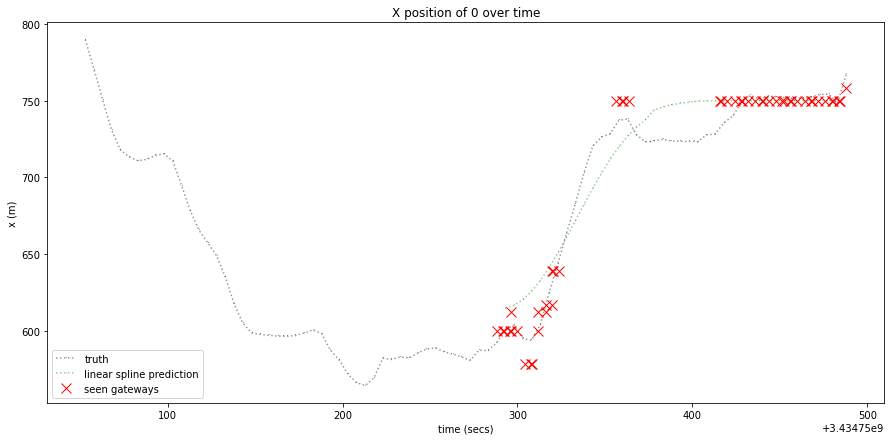

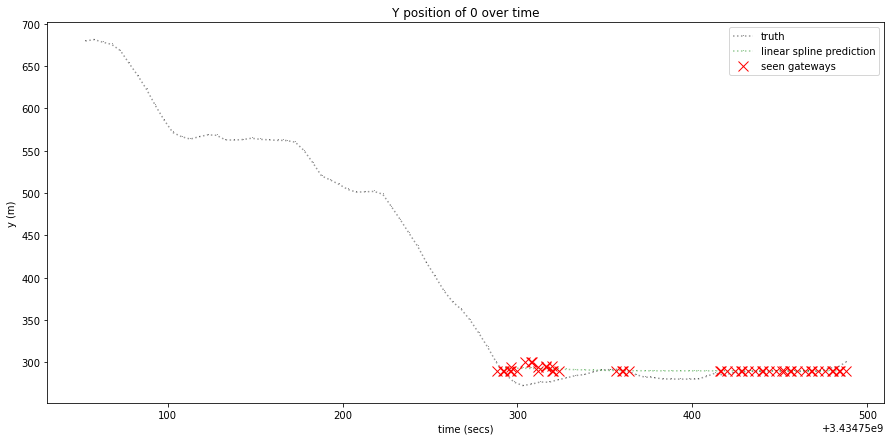

Average error: 15.407297984162787
Median error: 15.846368823095315


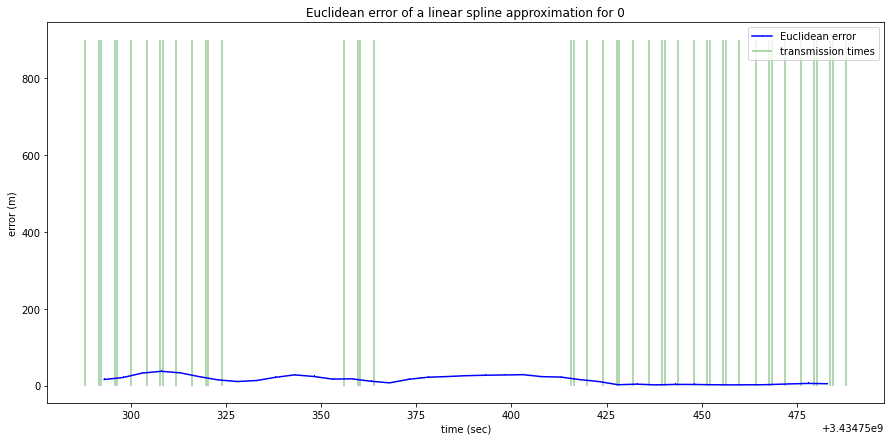

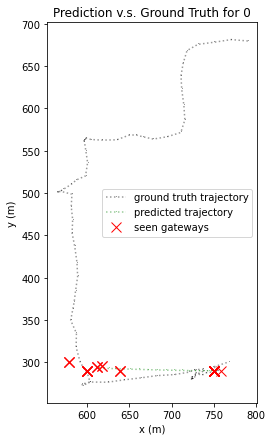

In [20]:
path_prediction()

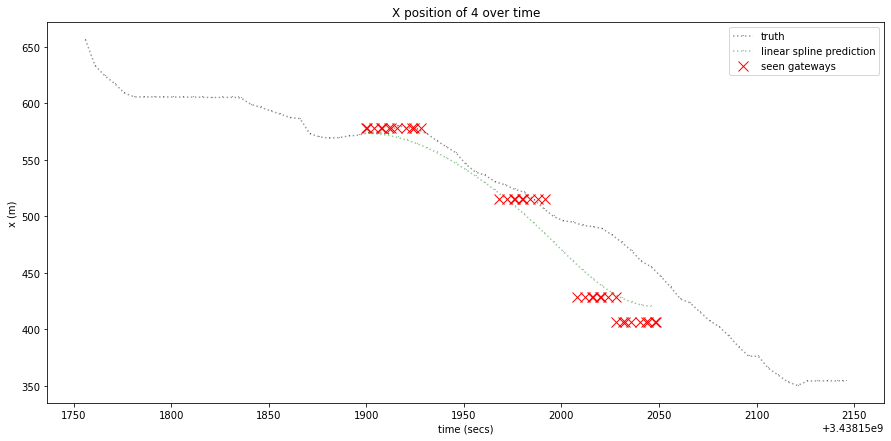

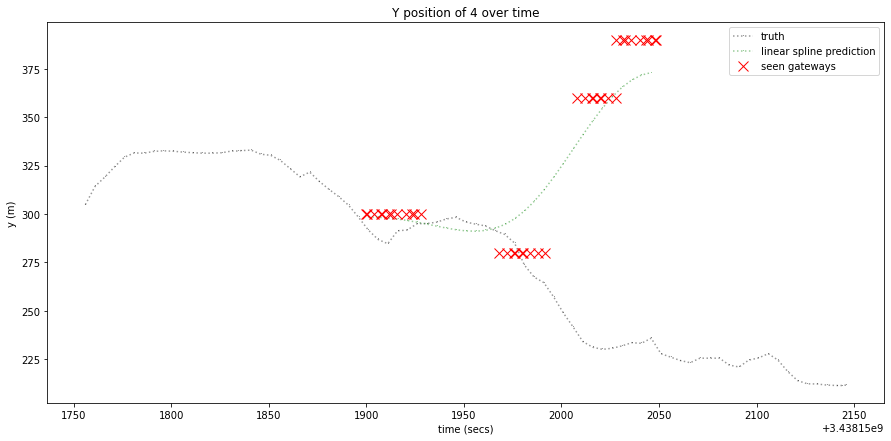

Average error: 54.39025826010699
Median error: 16.312409771992396


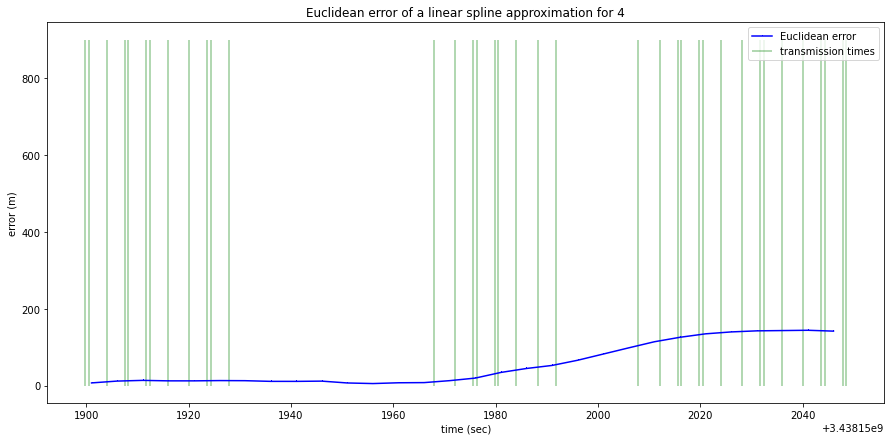

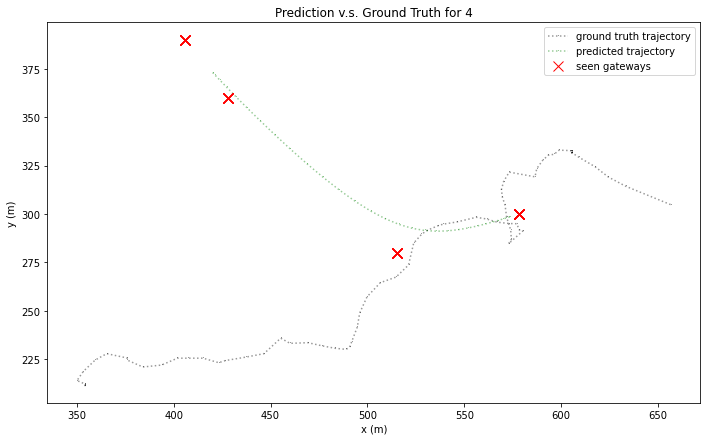

In [21]:
path_prediction(4)

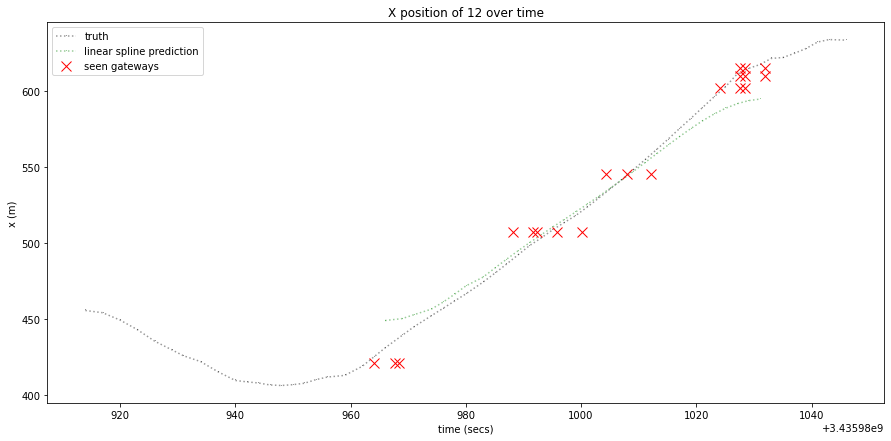

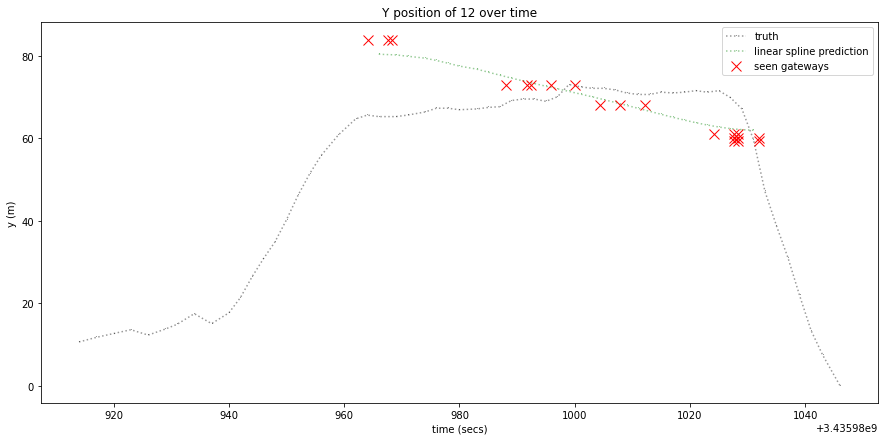

Average error: 9.828055688309808
Median error: 8.727790206715259


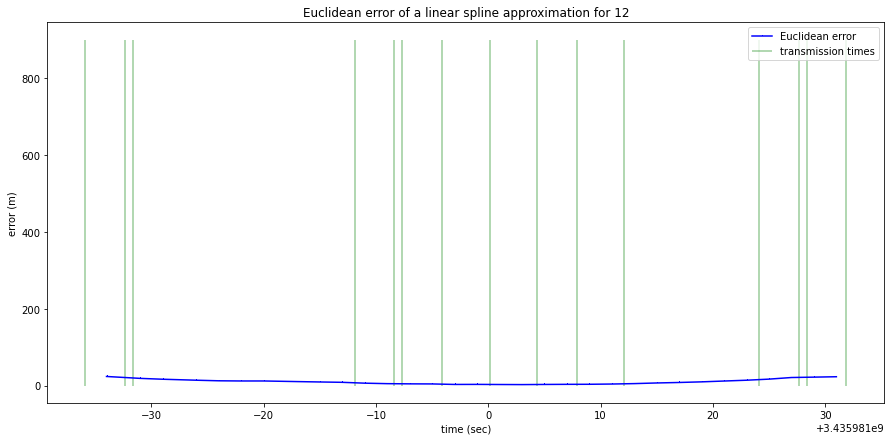

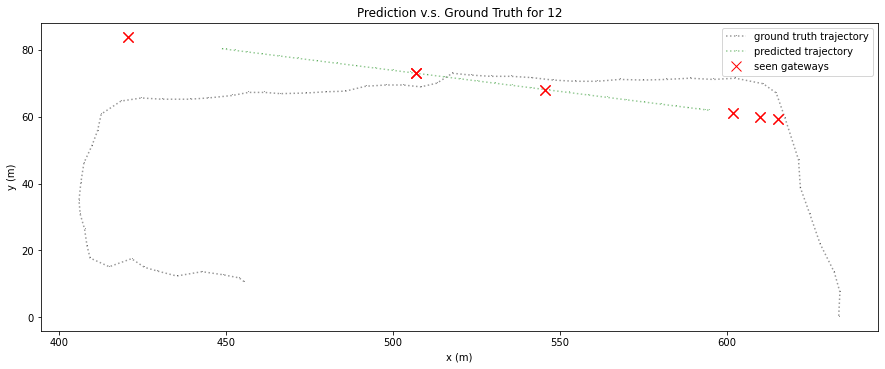

In [22]:
path_prediction(12)

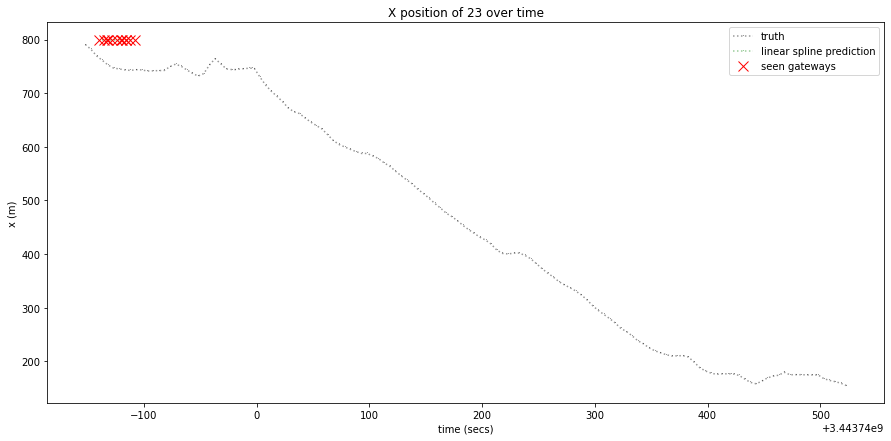

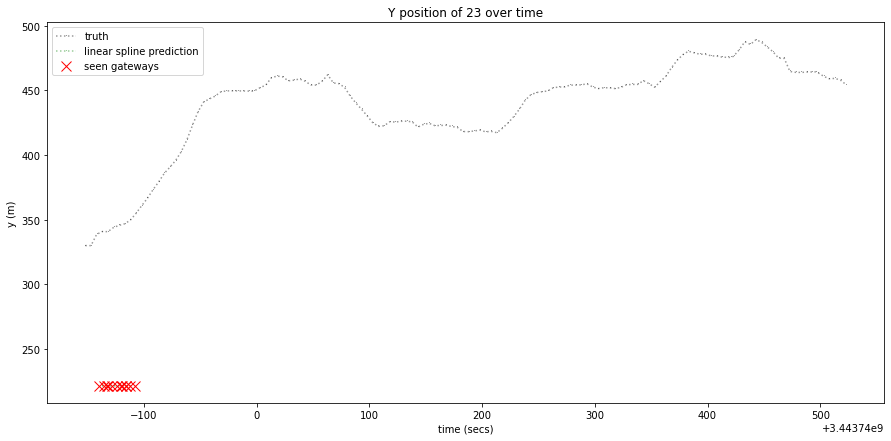

Average error: 133.1467961404338
Median error: 134.23076060743608


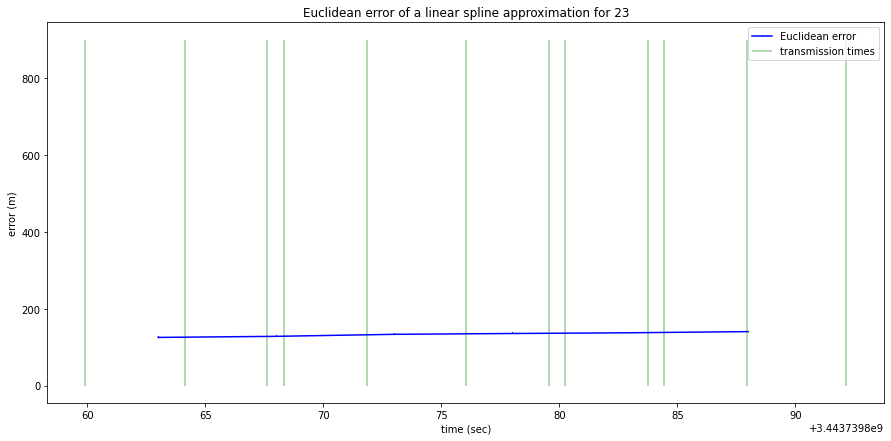

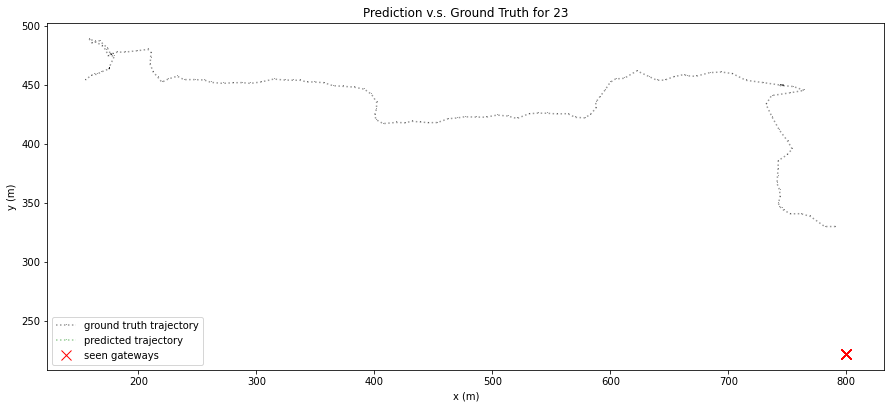

In [23]:
path_prediction(23)

## Results

Man, these results make me so sad. 

## Generate cooler figures

Ok. By orders of Jean-Luc Watson, we want to make a couple CDFs of (x-axis=number distance estimates/number times a gateway is seen, y-axis=fraction of gateways localized to within Z meters) with differnt lines for different Z. 

In [24]:
# First, we grab the number of times each gateway was seen. 
# This can be done by sifting through dist_diffs_list.

times_seen = np.zeros(num_gateways)
for matrix in dist_diffs_list:
    for index, row in enumerate(matrix):
        if np.any(row > 0):
            times_seen[index] += 1
            
print(times_seen)
print(max(times_seen))

[ 5.  0.  6.  0.  0.  0.  0.  2.  0.  1.  3.  8.  1.  0.  0. 14.  0.  2.
  1. 17. 11.  6. 18.  0. 11.  1. 14.  0.  0.  2.  8.  0.  0. 10. 17.  0.
  1.  1.  0. 11.  0.  4.  1.  3.  1. 11.  8. 20.  0.  4. 15.  0.  5.  1.
  0.  7.  0.  0.  0.  5.  1.  3.  6.  9. 11. 12. 14. 13. 10.  2.  0.  0.
 17. 18.  0.  5.]
20.0


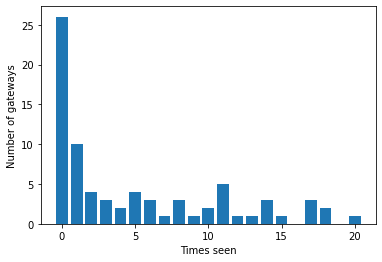

In [25]:
plt.figure()
labels, counts = np.unique(times_seen, return_counts=True)
#plt.hist(times_seen, bins=20)
plt.bar(labels, counts, align='center')
#plt.gca().set_xticks(labels)
#plt.title("number gateways seen for various times")
plt.ylabel("Number of gateways")
plt.xlabel("Times seen")

plt.savefig("hist_{}.png".format(num_known), dpi=800)
plt.show()

In [26]:
print(np.sum(times_seen >= 1))
print(np.sum(times_seen >= 3))
print(np.sum(times_seen >= 5))

50
36
31


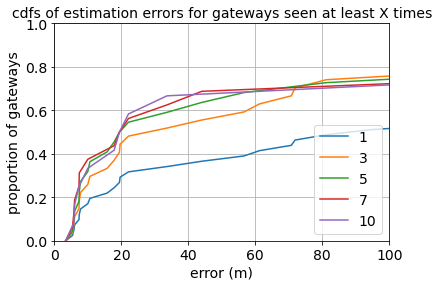

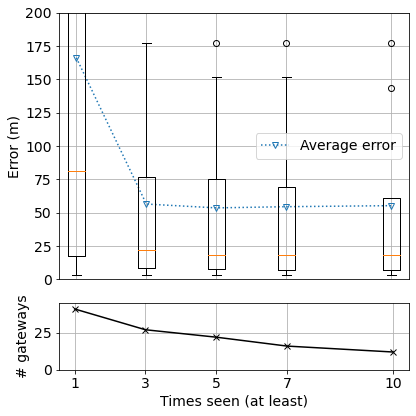

'\nplt.figure(figsize=(8,6))\nplt.plot(thresholds, sample_sizes)\nplt.title("number of gateways that meet this criteria (i.e. sample size)")\nplt.xlabel("times seen (at least)")\nplt.ylabel("number of gateways")\nplt.ylim([0, 50])\nplt.grid()\nplt.show()\nprint(sample_sizes)\n'

In [31]:
thresholds = [1, 3, 5, 7, 10]
average_errors = []
median_errors = []
error_lists = []
sample_sizes = []

# Shishir's formatting block
SMALL_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.figure()
for thresh in thresholds:
    mask = np.multiply(times_seen >= thresh, np.array([i not in known_ids for i in range(num_gateways)]))
    useful_errors = np.sort(np.linalg.norm(errors, axis=1)[mask])
    proportion = np.array(range(len(useful_errors)))/len(useful_errors)
    plt.plot(useful_errors, proportion, label=thresh)
    
    average_errors.append(np.mean(useful_errors))
    median_errors.append(np.median(useful_errors))
    error_lists.append(useful_errors)
    sample_sizes.append(len(useful_errors))

plt.title("cdfs of estimation errors for gateways seen at least X times")
plt.xlabel("error (m)")
plt.ylabel("proportion of gateways")
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

#plt.figure(figsize=(8,6))
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[4,1]}, figsize=[6,6])
a0.plot(thresholds, average_errors, linestyle=':', marker='v', fillstyle='none', label="Average error")
#plt.plot(thresholds, median_errors, label="median error")
a0.boxplot(error_lists, vert=True, positions=thresholds)
#a0.set_title("error v.s. times a gateway has been seen")
#a0.set_xlabel("times seen (at least)")
a0.set_ylabel("Error (m)")
a0.set_ylim([0,200])
a0.xaxis.set_ticks_position('none')
a0.xaxis.set_ticklabels([])
a0.grid()
a0.legend()

a1.plot(thresholds, sample_sizes, 'kx-')
#a1.set_title("number of gateways that meet this criteria (i.e. sample size)")
a1.set_xlabel("Times seen (at least)")
a1.set_ylabel("# gateways")
a1.set_ylim([0, 45])
a1.set_xticks(thresholds)
a1.grid()

f.tight_layout()
plt.savefig("errors_{}.png".format(num_known), dpi=800)
plt.show()

"""
plt.figure(figsize=(8,6))
plt.plot(thresholds, sample_sizes)
plt.title("number of gateways that meet this criteria (i.e. sample size)")
plt.xlabel("times seen (at least)")
plt.ylabel("number of gateways")
plt.ylim([0, 50])
plt.grid()
plt.show()
print(sample_sizes)
"""

In [28]:
# Now maybe try the number of relative distances we have for each gateway? 
# This can be done by sifting through dist_diffs.

num_dist_relations = np.zeros(num_gateways)
for index, row in enumerate(dist_diffs):
    num_dist_relations[index] = np.sum(row > 0)
            
print(num_dist_relations)
print(max(num_dist_relations))

[ 4.  0. 13.  0.  0.  0.  0.  9.  0.  3. 13. 14.  5.  0.  0.  6.  0.  3.
  5.  6. 13. 13. 19.  0. 16.  2. 17.  0.  0.  6. 13.  0.  0. 15.  6.  0.
  1.  3.  0. 15.  0. 10.  2.  5.  3. 11. 11. 20.  0.  5. 21.  0. 13.  5.
  0. 13.  0.  0.  0. 11.  5. 13. 14. 12. 15. 11. 16. 15. 13.  3.  0.  0.
  6.  8.  0.  3.]
21.0


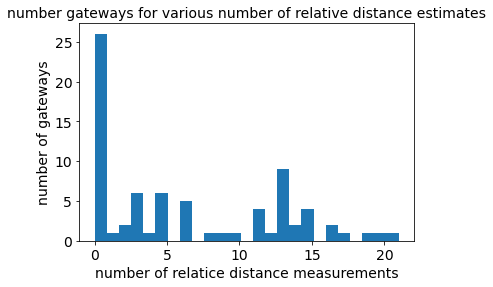

In [29]:
plt.figure()
plt.hist(num_dist_relations, bins=25)
plt.title("number gateways for various number of relative distance estimates")
plt.ylabel("number of gateways")
plt.xlabel("number of relatice distance measurements")
plt.show()

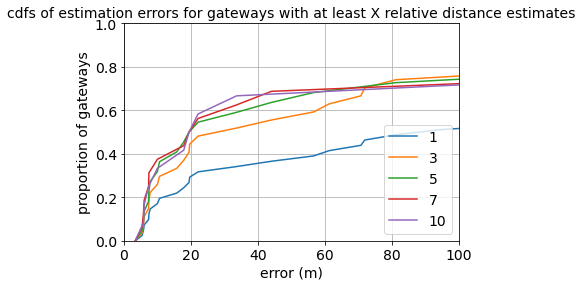

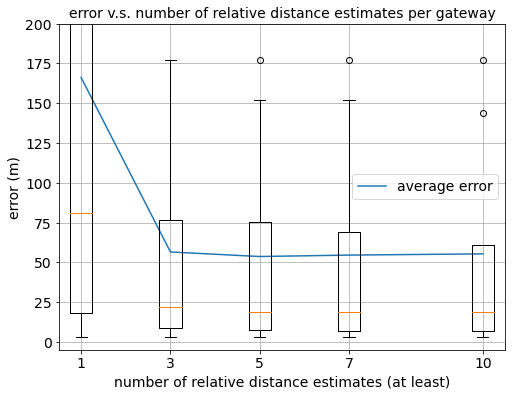

In [30]:
thresholds = [1, 3, 5, 7, 10]
average_errors = []
median_errors = []
error_lists = []

plt.figure()
for thresh in thresholds:
    mask = np.multiply(times_seen >= thresh, np.array([i not in known_ids for i in range(num_gateways)]))
    useful_errors = np.sort(np.linalg.norm(errors, axis=1)[mask])
    proportion = np.array(range(len(useful_errors)))/len(useful_errors)
    plt.plot(useful_errors, proportion, label=thresh)
    
    average_errors.append(np.mean(useful_errors))
    median_errors.append(np.median(useful_errors))
    error_lists.append(useful_errors)

plt.title("cdfs of estimation errors for gateways with at least X relative distance estimates")
plt.xlabel("error (m)")
plt.ylabel("proportion of gateways")
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(thresholds, average_errors, label="average error")
#plt.plot(thresholds, median_errors, label="median error")
plt.boxplot(error_lists, vert=True, positions=thresholds)
plt.title("error v.s. number of relative distance estimates per gateway")
plt.xlabel("number of relative distance estimates (at least)")
plt.ylabel("error (m)")
plt.ylim([-5,200])
plt.grid()
plt.legend()
plt.show()

## Generate a table of aggregate data

We want the table to look something like

|  | meters (or seconds?) predicted | average error \pm std | # usable gateways | average gateway error \pm std | 
| --- | --- | --- | --- | --- |
| perfect knowledge | 
| all guessed gateways |
| gateways seen more than three times | 

Labels might be changed but that's the general idea.

In [ ]:
mobile_id = 0


In [ ]:
if (row['id'] in np.where(times_seen >= 3)[0]) or (row['id'] in known_ids):

In [48]:
def get_specs(gateways_used, gateway_positions, mobile_id, sample_period=4, spline_type='linear', filter_std=5):
    # Read in path simulation and ground truth files
    sim = pd.read_csv("../ground_truth/interactions/{}.csv".format(mobile_id))
    truth = pd.read_csv("../ground_truth/mules/{}.csv".format(mobile_id))
    
    # Downsample the simulation.
    down_sim = sim.loc[(sim['seconds'].round() % sample_period) == 0]
    
    # Compile positions of seen gateways.
    t = []
    sim_x = []
    sim_y = []

    for index, row in down_sim.iterrows():
        if row['id'] in gateways_used:
            t.append(row['seconds'])
            sim_x.append(gateway_positions[int(row['id']), 0])
            sim_y.append(gateway_positions[int(row['id']), 1])
    
    # if we don't see any gateways, just return nothing
    if len(t) < 2:
        return 0, []
    
    # The goal is to spline. However, splines dont work well with multiple values
    # at one point, which happens when we see multiple gateways at the same time.
    # Thus, if we see multiple gateways at the same time, we average the positions.
    ct = []
    cx = []
    cy = []

    counter = 0
    while counter < len(t):
        cur_t = t[counter]
        cum_x = [sim_x[counter]]
        cum_y = [sim_y[counter]]
        counter += 1
        while counter < len(t) and t[counter] == cur_t:
            cum_x.append(sim_x[counter])
            cum_y.append(sim_y[counter])
            counter += 1
        ct.append(cur_t)
        cx.append(sum(cum_x) / len(cum_x))
        cy.append(sum(cum_y) / len(cum_y))
    
    # if we don't have enough points, just return nothing
    if len(ct) < 2:
        return 0, []
    
    # Calculate our predictions.
    fx = interp1d(ct, cx, kind=spline_type)
    fy = interp1d(ct, cy, kind=spline_type)
    tt = truth.loc[(truth['seconds'] > ct[0]) & 
                   (truth['seconds'] < ct[-1])]['seconds'].to_numpy()

    # if we can't predict anything, return nothing
    if len(tt) < 2:
        return 0, []
    
    # Predict points based on a spline and apply a Gaussian filter to smooth the points.
    px = gaussian_filter1d(fx(tt), filter_std)
    py = gaussian_filter1d(fy(tt), filter_std)

    # Calculate the Euclidean error of the prediction for each truth point.
    err = []
    for i in range(len(tt)):
        ex = px[i] - truth.loc[truth['seconds'] == tt[i]].iloc[0]['x']
        ey = py[i] - truth.loc[truth['seconds'] == tt[i]].iloc[0]['y']
        err.append(np.linalg.norm([ex, ey]))

    time_span = tt[-1] - tt[0]
    
    return time_span, err

In [60]:
# perfect knowledge
gateways_used = [i for i in range(num_gateways)]
gateway_positions = truth_df[['x','y']].to_numpy()

time_spans = []
errors = []
for sensor_path in tqdm(glob.iglob('../ground_truth/interactions/*.csv')):
    # Import the simulated mobile sensor connection metadata.
    mobile_id = sensor_path.split('\\')[-1][:-4]
    ts, err = get_specs(gateways_used, gateway_positions, mobile_id)
    #if ts > 0:
    time_spans.append(ts)
    errors.append(err)

1035it [00:50, 20.69it/s]


In [61]:
# printout specs
long_errors = np.concatenate(errors)
gateway_errors = np.linalg.norm(gateway_positions - truth_df[['x','y']].to_numpy(), axis=1)[gateways_used]

print("Number of minutes estimated: {}".format(sum(time_spans)))
print("Average error and standard deviation: {} ({})".format(np.mean(long_errors), np.std(long_errors)))
print("Number of gateways used: {}".format(len(gateways_used)))
print("Average gateway error and standard deviation: {} ({})".format(np.mean(gateway_errors), np.std(gateway_errors)))

Number of minutes estimated: 137465.0000514984
Average error and standard deviation: 18.643197529706008 (24.476605271803148)
Number of gateways used: 76
Average gateway error and standard deviation: 0.0 (0.0)


In [57]:
sum(time_spans)

137465.0000514984

In [58]:
long_errors = np.concatenate(errors)
np.mean(long_errors)

18.643197529706008

In [38]:
truth_df[['x','y']].to_numpy()


array([[231.2663, 120.1813],
       [371.8589, 238.2076],
       [757.0289, 350.5063],
       [190.94  , 140.1613],
       [663.134 , 522.301 ],
       [681.005 , 674.8039],
       [698.1989, 561.4063],
       [577.9526, 458.5426],
       [210.1763, 808.5589],
       [275.1113, 157.3663],
       [ 60.737 , 468.466 ],
       [306.5576, 214.1539],
       [703.9376, 601.3663],
       [265.6763, 931.4026],
       [567.2189, 798.58  ],
       [622.3526,  57.8326],
       [562.013 , 591.676 ],
       [710.9639, 663.7039],
       [ 18.8789, 645.3889],
       [550.5689,  70.9639],
       [636.0389, 280.5763],
       [670.0826, 296.305 ],
       [489.8963, 229.6939],
       [ 43.1213,  25.6426],
       [314.705 , 219.8926],
       [724.8389, 592.1089],
       [584.0576, 283.1626],
       [197.9663, 793.9513],
       [544.697 , 624.643 ],
       [ 95.2913, 201.0226],
       [790.1513, 350.695 ],
       [695.8013, 563.6263],
       [ 48.8489, 655.9339],
       [614.96  , 272.8063],
       [600.51